# MACS1206 Sinfoni Data

- Cubes do not have an associated variance: create a variance spectra
- (Correct the cube background)
- Mask bad voxels: both in wavelenght and spatial pixels
- Make Pseudo Narrow Bands from SINFONI data
- Compare SINFONI and HST data to check flux calibration 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
from astropy.io import fits
from astropy import wcs
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.convolution import Gaussian1DKernel,Gaussian2DKernel,Moffat2DKernel,convolve
from astropy.modeling import models, fitting
from astropy import units as u
from reproject import reproject_interp, reproject_exact
from lmfit import minimize, Parameters
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle,Circle

In [5]:
cube = fits.getdata('../Data/Cubes/087.A-0700_MACSJ1206J.fits')
header = fits.getheader('../Data/Images/MACS1206/MACS1206Jwcscorrected.fits')
spec_header = fits.getheader('../Data/Cubes/087.A-0700_MACSJ1206J.fits')
cube[np.where(cube==0.00000000e+00)] = np.nan # mask mosaic part that has not been observed

def wav2pix(wav):
    return int((wav-spec_header['CRVAL3'])/spec_header['CDELT3'])

wave = [spec_header['CRVAL3']+i*spec_header['CDELT3'] for i in range(cube.shape[0])] 
trim_pix = 1690
wave_trim = wave[250:trim_pix]

# White light
white_im = np.nanmean(cube[250:trim_pix,:,:],axis=0)

# Variance

Cubes do not have an associated variance. Calculate a variance spectrum by choosing an empty box and calculating the standard deviation for each plane

<IPython.core.display.Javascript object>


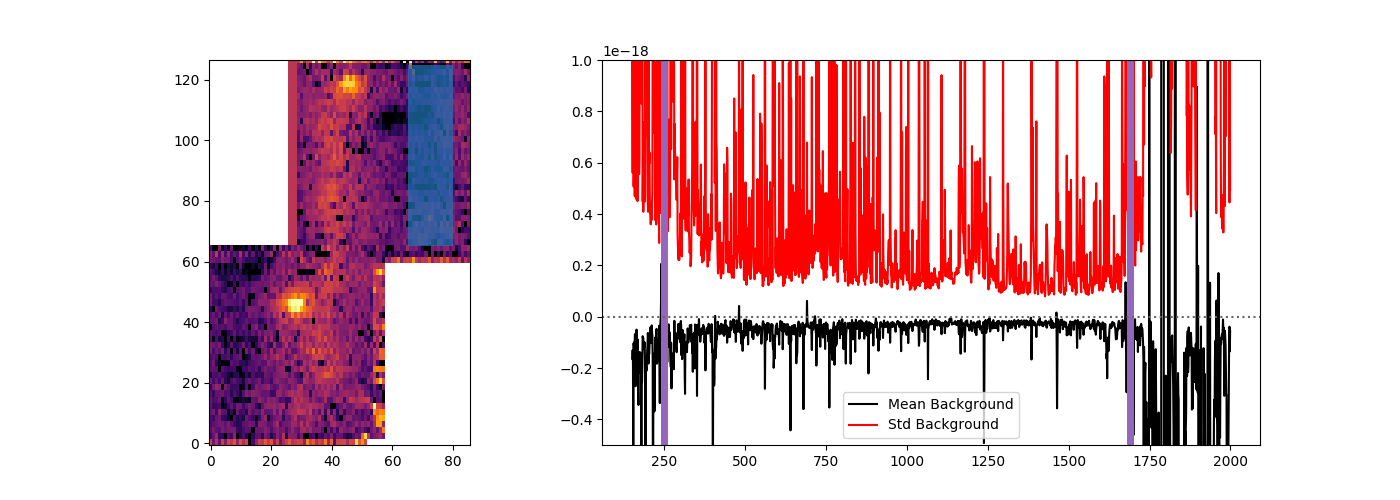

In [4]:
sp_noise = []
sp_background = []

# Noise box
fig, ax = plt.subplots(1,2,figsize=(14,5),gridspec_kw={'width_ratios':[1,2]})
rect = Rectangle((65, 65), 15, 60, alpha=0.7)
ax[0].add_artist(rect)
ax[0].imshow(white_im,cmap=plt.cm.inferno,vmin=-1e-19,vmax=1e-19,origin='lower')

# Spectra
for k in range(cube.shape[0]):
    sp_noise.append(np.nanstd(cube[k,65:,70:]))
    sp_background.append(np.nanmean(cube[k,65:,70:]))
    
sp_noise = np.array(sp_noise)
sp_background = np.array(sp_background)


ax[1].plot(sp_background,color='k',label='Mean Background')
ax[1].plot(sp_noise,color='r',label='Std Background')
ax[1].axvline(250,color='C4',linewidth=5)
ax[1].axvline(1690,color='C4',linewidth=5)
ax[1].set_ylim(-0.05e-17,0.1e-17)
ax[1].axhline(0,color='0.4',linestyle=':')
ax[1].legend()

### Save noise spectrum

<IPython.core.display.Javascript object>


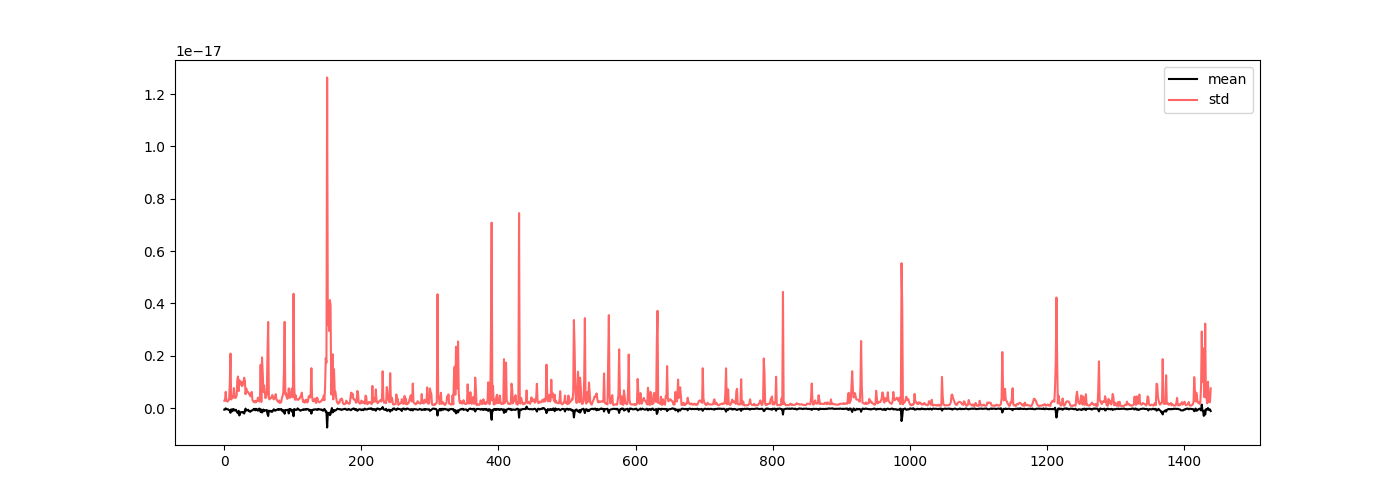

('Average background', -4.9925902233401113e-20)


In [6]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
ax.plot(sp_background[250:trim_pix],color='k',label='mean')
ax.plot(sp_noise[250:trim_pix],color='r',alpha=0.6,label='std')
plt.legend()
print('Average background',np.nanmean(sp_background[250:1680]))

# Save spectra
prihdr = fits.Header()
prihdr['CRVAL1'] = wave[0]
prihdr['CRPIX1'] = 1
prihdr['CDELT1'] = wave[1]-wave[0]
prihdr['CUNIT1']= 'Angstrom'
fits.writeto('Spectrum_SINFONI_MACS1206_background.fits',sp_background, prihdr,output_verify='fix',clobber=True)
fits.writeto('Spectrum_SINFONI_MACS1206_std.fits',sp_noise, prihdr,output_verify='fix',clobber=True)

### Correct cube by subtracting the backgound in each wavelenght plane

    Not doing this after talking with Céline and Johan

<IPython.core.display.Javascript object>


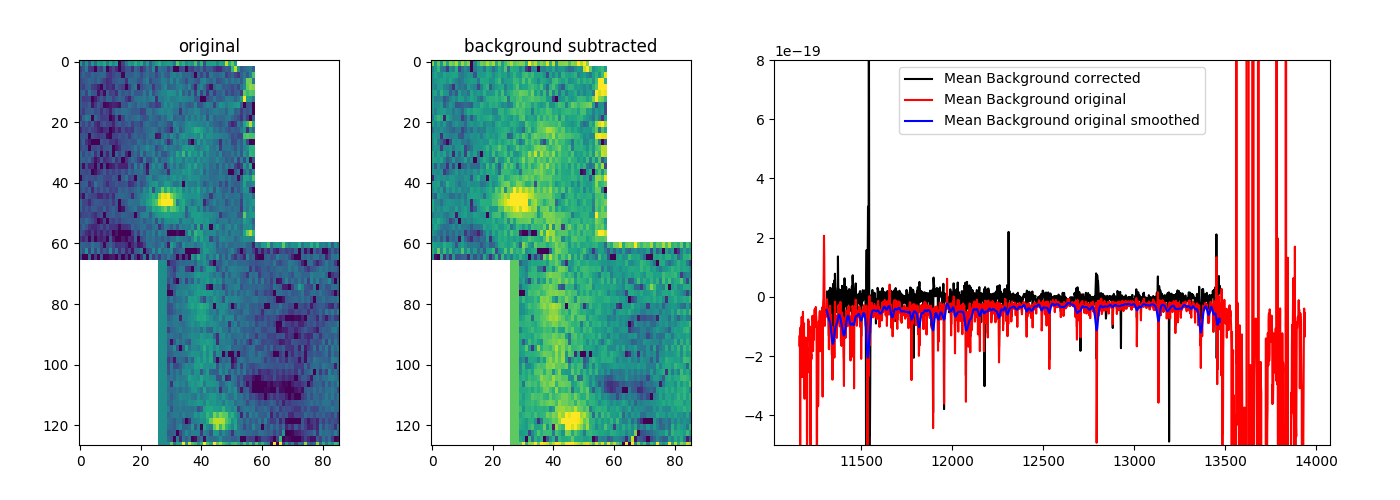

New average background -1.01e-20


In [8]:
# Smooth background spectra to make sure spikes are not subtracted
kernel = Gaussian1DKernel(stddev=4)
sp_bg_smooth = convolve(sp_background, kernel)

#Trim very bad edges and correct cube
bgcorr_cube = []
for k in range(250,trim_pix):
    bgcorr_cube.append(cube[k,:,:] - sp_bg_smooth[k])
bgcorr_cube = np.array(bgcorr_cube)

# Plotting
fig, ax = plt.subplots(1,3,figsize=(14,5),gridspec_kw={'width_ratios':[1,1,2]})
fig.subplots_adjust(left=0.05,right=0.95)

# Check differences in white light
white_im_bgcorr = np.nanmean(bgcorr_cube[:trim_pix,:,:],axis=0)
ax[0].imshow(white_im,vmin=-1e-19,vmax=1e-19)
ax[1].imshow(white_im_bgcorr,vmin=-1e-19,vmax=1e-19)
ax[0].set_title('original')
ax[1].set_title('background subtracted')

# Extract new background and noise spectra to check
sp_noise_check = []
sp_background_check = []
for k in range(bgcorr_cube.shape[0]):
    sp_noise_check.append(np.nanstd(bgcorr_cube[k,65:125,65:80]))
    sp_background_check.append(np.nanmean(bgcorr_cube[k,65:125,65:80]))
ax[2].plot(wave[250:trim_pix],sp_background_check,color='k',label='Mean Background corrected')
ax[2].plot(wave,sp_background,color='r',label='Mean Background original')
ax[2].plot(wave[250:trim_pix],sp_bg_smooth[250:trim_pix],color='b',label='Mean Background original smoothed')

ax[2].set_ylim(-5e-19,8e-19)
ax[2].legend()

print('New average background %0.2e'%np.nanmean(sp_background_check))
#fits.writeto('../Data/Cubes/Cube_SINFONI_MACS1206_background_corrected.fits',bgcorr_cube, header,output_verify='fix',clobber=True)

##  Clip bad pixels

In [11]:
# Make white light but with sigma clipping
clip_cube = sigma_clip(cube,sigma=7,iters=5,cenfunc=np.ma.median,stdfunc=np.std)
clip_cube_bgcorr = sigma_clip(bgcorr_cube,sigma=7,iters=5,cenfunc=np.ma.median,stdfunc=np.std)
clip_white_im = np.ma.mean(clip_cube,axis=0)
clip_white_im_bgcorr = np.ma.mean(clip_cube_bgcorr,axis=0)

## Some stats
print('bg corr: STD all',np.nanstd(cube),' empty box',np.nanstd(cube[:,65:125,65:80]))
print('clipped: STD all',np.nanstd(clip_cube),' empty box',np.nanstd(clip_cube[:,65:125,65:80]))
print('bg corr and clipped: STD all',np.nanstd(clip_cube_bgcorr),' empty box',np.nanstd(clip_cube_bgcorr[:,65:125,65:80]))

('bg corr: STD all', 9.207647105190147e-19, ' empty box', 1.1934769458987677e-18)
('clipped: STD all', 1.9795881251862098e-19, ' empty box', 1.963579281214595e-19)
('bg corr and clipped: STD all', 1.9795881251862098e-19, ' empty box', 1.963579281214595e-19)


<IPython.core.display.Javascript object>


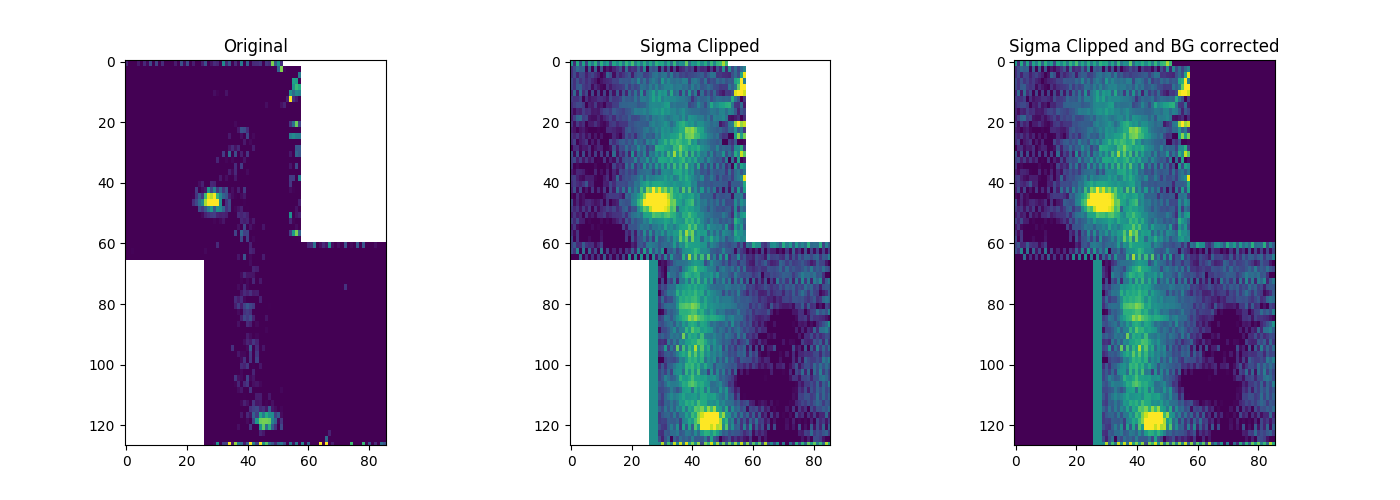

Text(0.5,1,u'Sigma Clipped and BG corrected')

In [12]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
fig.subplots_adjust(left=0.05,right=0.95)

ax[0].imshow(white_im,vmin=0,vmax=1e-19)
ax[1].imshow(clip_white_im,vmin=0,vmax=1e-19)
ax[2].imshow(clip_white_im_bgcorr.data,vmin=0,vmax=1e-19)

ax[0].set_title('Original')
ax[1].set_title('Sigma Clipped')
ax[2].set_title('Sigma Clipped and BG corrected')

In [13]:
# Save cube
header_cube = header.copy()
header_cube['NAXIS'] = 3
header_cube['NAXIS3'] = len(wave[250:trim_pix])
header_cube['CRVAL3'] = wave[250]
header_cube['CRPIX3'] = 1
header_cube['CDELT3'] = wave[1]-wave[0]
header_cube['CUNIT3']= 'Angstrom'
header_cube['SIGCLIP']= 7
header_cube['SIGAXIS'] = 3

# masked arrays are still not emplemented. put mask to nan
clip_cube[np.where(clip_cube.mask==True)]  = np.nan

fits.writeto('../Data/Cubes/Cube_SINFONI_MACS1206_sigmaclipped.fits',clip_cube.data, header,output_verify='fix',clobber=True)

# Check phometry

We use the cluster members in the image to check the photometry and measure the psf. Make pseudo HST images from the SINFONI cubes and compare them with HST F125W data.

We use HST croped images:

| Image  | PHOTPLAM  |  PHOTFLAM  |  Zero Point |
|---|---|---|
|hlsp_clash_hst_wfc3ir-30mas_macs1206_f125w_v1_drz.fits  | 12486.060 |2.2132778E-20 |26.2481 |
|hlsp_clash_hst_wfc3ir-30mas_macs1206_f160w_v1_drz.fits  | 15369.172 |1.9106045E-20 |25.9566 |

with zero point calculated as -2.5*log(PHOTPLAM x PHOTPLAM x PHOTFLAM /3e18)/log(10)-48.6)

see more in http://www.stsci.edu/hst/acs/analysis/zeropoints

    SINFONI spatial scale: CDELT1 =  -3.47222E-05 degrees --> 0.125 "/pix 
    HST spatial scale: PC1_1: 8.33333333333334E-06 --> 0.03 "/pix

In [6]:
def make_F125W_pseudo_narrow_band(cube,cube_wave):
    # Load filters
    w, t = np.loadtxt('HST_WFC3_IR.F125W.dat',unpack=True)
    # Interpolate the transmission to the cube's wavelenght:
    inter_t = np.interp(cube_wave,w,t)
    cube2 = [cube[k,:,:]*inter_t[k] for k in range(len(cube_wave))]
    return np.nansum(cube2,axis=0)/np.sum(inter_t)

def hst_magnitudes_F125W(hst_pix):
    return (-2.5 * np.log10(np.sum(hst_pix)) + 26.2481)* u.ABmag

def sinfoni_magnitude(sinf_pix):
    return (np.sum(sinf_pix) *u.erg/u.s/u.cm**2/u.AA ).to(u.ABmag,u.spectral_density(12486.060*u.AA))

1) Make pseudo F125 narrow band

In [7]:
cube = fits.getdata('../Data/Cubes/Cube_SINFONI_MACS1206_sigmaclipped.fits')
pseudo_F125W = make_F125W_pseudo_narrow_band(cube, wave_trim)
fits.writeto('../Data/Images/MACS1206_SINFONI_pseudoF125W.fits',pseudo_F125W,header=header,output_verify='fix',clobber=True)
pseudo_F125W *=1e19 

hst_im = fits.getdata('../Data/HST/MACS1206_arc_F125w.fits')

2) Fit Moffats to the cluster members in the images:

\begin{equation}
        f(x, y) = A \left(1 + \frac{\left(x - x_{0}\right)^{2} + \left(y - y_{0}\right)^{2}}{\gamma^{2}}\right)^{- \alpha}
\end{equation}

Works much better than Gaussians. Convert $\gamma$ and $\alpha$ to FWHM:

FWHM = $\gamma * (2 \sqrt{2^{1/\alpha}-1})$ 


http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/PSFsAndSampling.pdf

In [8]:
def fwhm(alpha,gamma):
    return gamma.value*(2*np.sqrt(2**(1./alpha.value) - 1))

def measure_flux_in_apperture(im,x_center,y_center,radius,bg):
    x, y = np.meshgrid(range(im.shape[0]),range(im.shape[1]))
    inside = np.where(np.sqrt((x-x_center)**2+(y-y_center)**2) <= radius)
    return np.nansum(im[inside]) - bg*len(inside[0])

# Fitting
fit_cm = fitting.LevMarLSQFitter()

#### SINFONI

<IPython.core.display.Javascript object>


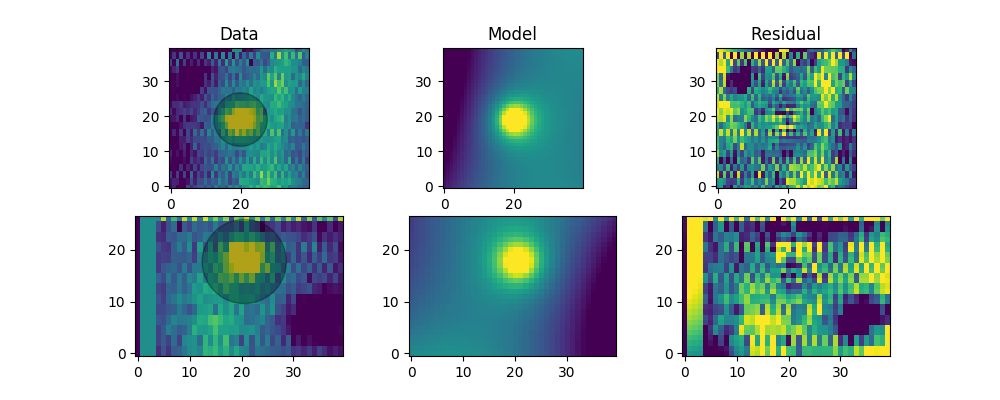

			CM1	CM2
Chi2			2.98e+01 3.65e+01
FWHM			6.0162 6.3890
FWHM(")			0.7520 0.7986
    amplitude_0		1.64	1.26
          x_0_0		19.04	17.72
          y_0_0		19.95	20.52
        gamma_0		2.45	2.29
        alpha_0		0.75	0.64
         c0_0_1		0.01	0.42
         c1_0_1		-0.01	-0.02
         c2_0_1		0.00	0.00
         c0_1_1		0.03	0.01
         c0_2_1		-0.00	-0.00
         c1_1_1		0.00	0.00

Background/pix 2.5135e-20
CM1 photometry 19.70 mag or 9.1893e-18 erg/cm2/s
CM2 photometry 20.04 mag 6.7471e-18 erg/cm2/s

Aperture sizes in HST pix: CM1 31.84, CM2 33.81


In [9]:
# Cluster member positions
y_cm1,x_cm1 = (47,28) 
y_cm2,x_cm2 = (120,45)
d = 20

# Models: Moffat plus a background
bg = models.Polynomial2D(2)
cm1 = models.Moffat2D(amplitude=1.,x_0=d,y_0=d,alpha=1,gamma=1) +  bg
cm2 = models.Moffat2D(amplitude=1.,x_0=d,y_0=d,alpha=1,gamma=1) + bg

cm1_data = pseudo_F125W[y_cm1-d:y_cm1+d,x_cm1-d:x_cm1+d]
y1, x1 = np.mgrid[:cm1_data.shape[0], :cm1_data.shape[1]]
p_cm1 = fit_cm(cm1,y1,x1,cm1_data)

cm2_data = pseudo_F125W[y_cm2-d:y_cm2+d,x_cm2-d:x_cm2+d]
y2, x2 = np.mgrid[:cm2_data.shape[0], : cm2_data.shape[1]]
p_cm2 = fit_cm(cm2,y2,x2,cm2_data)

# Plot the data with the best-fit model
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(2, 3, 1)
plt.imshow(cm1_data, origin='lower', interpolation='nearest', vmin=0, vmax=1)
plt.title("Data")
plt.subplot(2, 3, 2)
plt.imshow(p_cm1(y1, x1), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.title("Model")
plt.subplot(2, 3, 3)
plt.imshow(cm1_data - p_cm1(y1, x1), origin='lower', interpolation='nearest', vmin=-0.2,vmax=0.2)
plt.title("Residual")
ax2 = plt.subplot(2, 3, 4)
plt.imshow(cm2_data, origin='lower', interpolation='nearest', vmin=0, vmax=1)
plt.subplot(2, 3, 5)
plt.imshow(p_cm2(y2, x2), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.subplot(2, 3, 6)
plt.imshow(cm2_data - p_cm2(y2, x2), origin='lower', interpolation='nearest', vmin=-0.2,vmax=0.2)

print('\t\t\tCM1\tCM2')
print('Chi2\t\t\t%0.2e %0.2e'%(np.sum((cm1_data - p_cm1(y1, x1))**2),np.sum((cm2_data - p_cm2(y2, x2))**2)))
print('FWHM\t\t\t%0.4f %0.4f'%(fwhm(p_cm1.alpha_0,p_cm1.gamma_0),fwhm(p_cm2.alpha_0,p_cm2.gamma_0)))
print('FWHM(")\t\t\t%0.4f %0.4f'%(fwhm(p_cm1.alpha_0,p_cm1.gamma_0)*0.12499992,fwhm(p_cm2.alpha_0,p_cm2.gamma_0)*0.12499992))
for name,p1,p2 in zip(p_cm1.param_names,p_cm1.parameters,p_cm2.parameters):
    print('%15s\t\t%0.2f\t%0.2f'%(name,p1,p2))
    
# Photometry: measure inside 1.27 FWHM (corresponds to 3 sigma in gaussian), subtract background and calculate photometry
mean_bg,median_bg, std = sigma_clipped_stats(pseudo_F125W[10:80,50:60])
print('\nBackground/pix %0.4e'%(mean_bg*1e-19))

phot_cm1 = measure_flux_in_apperture(cm1_data,p_cm1.x_0_0,p_cm1.y_0_0,1.27*fwhm(p_cm1.alpha_0,p_cm1.gamma_0),mean_bg)*1e-19
print('CM1 photometry %0.2f mag or %0.4e erg/cm2/s'%(sinfoni_magnitude(phot_cm1).value,phot_cm1))

cm2_data_fixed = np.zeros_like(cm1_data)
cm2_data_fixed[:cm2_data.shape[0],:cm2_data.shape[1]] = cm2_data[:,:]
phot_cm2 = measure_flux_in_apperture(cm2_data_fixed,p_cm2.x_0_0,p_cm2.y_0_0,1.27*fwhm(p_cm2.alpha_0,p_cm2.gamma_0),mean_bg)*1e-19
print('CM2 photometry %0.2f mag %0.4e erg/cm2/s'%(sinfoni_magnitude(phot_cm2).value,phot_cm2))    

print('\nAperture sizes in HST pix: CM1 %0.2f, CM2 %0.2f'%(1.27*fwhm(p_cm1.alpha_0,p_cm1.gamma_0)*0.125/0.03,1.27*fwhm(p_cm2.alpha_0,p_cm2.gamma_0)*0.125/0.03))

ax1.add_artist(Circle((p_cm1.y_0_0.value,p_cm1.x_0_0.value), radius=1.27*fwhm(p_cm1.alpha_0,p_cm1.gamma_0), alpha=0.3,color='k'))
ax2.add_artist(Circle((p_cm2.y_0_0.value,p_cm2.x_0_0.value), radius=1.27*fwhm(p_cm2.alpha_0,p_cm2.gamma_0), alpha=0.3,color='k'))

#### HST data

Moffat
			CM1	CM2
Chi2			2.93 2.00
FWHM			9.5115 7.9103
FWHM(")			0.2853 0.2373
    amplitude_0		1.57	1.51
          x_0_0		39.54	40.18
          y_0_0		42.26	39.79
        gamma_0		6.87	5.21
        alpha_0		1.77	1.52
         c0_0_1		0.01	0.03
         c1_0_1		0.00	-0.00
         c0_1_1		-0.00	-0.00

Gaussian
Chi2			5.14 4.00
    amplitude_0		1.31	1.22
       x_mean_0		39.50	40.17
       y_mean_0		42.26	39.88
     x_stddev_0		4.64	4.72
     y_stddev_0		5.40	4.02
        theta_0		2.09	0.25
         c0_0_1		0.02	0.04
         c1_0_1		0.00	-0.00
         c0_1_1		-0.00	-0.00


Photometry inside 1.27*FWHM (USING MOFFAT)
Background/pix 0.0009
CM1 pix sum 211.35 and photometry 20.44 mag or 4.6778e-18 erg/cm2/s
CM2 pix sum 141.98 and photometry 20.87 mag or 3.1425e-18 erg/cm2/s


Photometry inside the SINFONI apperture (USING MOFFAT)
CM1 pix sum 341.05 and photometry 19.92 mag or 7.5483e-18 erg/cm2/s
CM2 pix sum 250.27 and photometry 20.25 mag or 5.5392e-18 erg/cm2/s


<IPython.core.display.Javascript object>


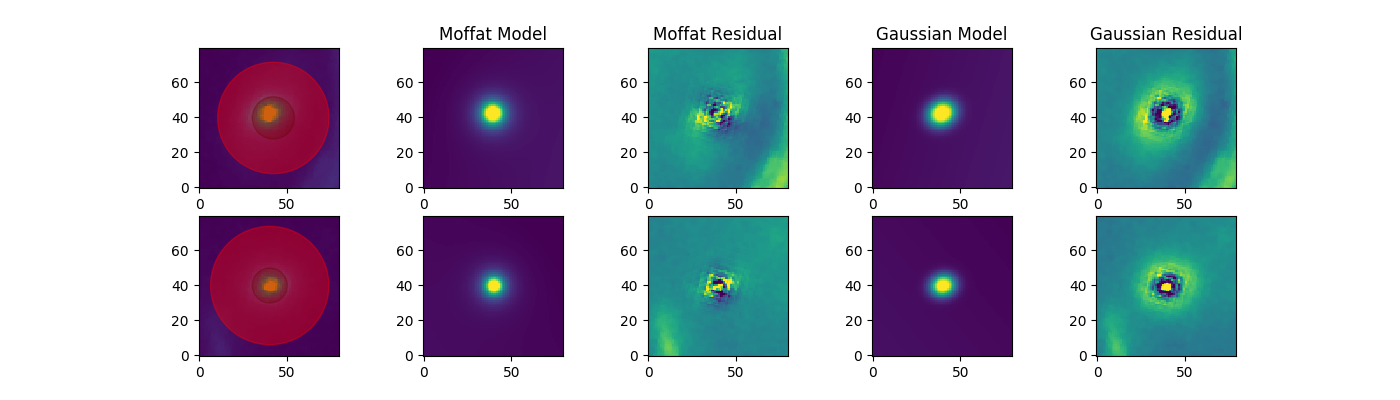

In [25]:
# Cluster member positions
y_cm1,x_cm1 = (233,90)
y_cm2,x_cm2 = (538,160) 
d = 40

# Models 1: Moffat plus a background
bg = models.Polynomial2D(1)
cm1_moffat = models.Moffat2D(amplitude=1.,x_0=d,y_0=d,alpha=1,gamma=1) +  bg
cm2_moffat = models.Moffat2D(amplitude=1.,x_0=d,y_0=d,alpha=1,gamma=1) + bg

# Models 2: Gausian plus a background
#cm1_sersic = models.Gaussian2D(amplitude=1.,x_mean=d,y_mean=d,x_stddev=3.,y_stddev=2.) + bg
#cm2_sersic = models.Gaussian2D(amplitude=1.,x_mean=d,y_mean=d,x_stddev=3.,y_stddev=2.) + bg

cm1_data = hst_im[y_cm1-d:y_cm1+d,x_cm1-d:x_cm1+d]
y, x = np.mgrid[:cm1_data.shape[0], : cm1_data.shape[1]]
m_cm1 = fit_cm(cm1_moffat,x,y,cm1_data)
#s_cm1 = fit_cm(cm1_sersic,x,y,cm1_data)

cm2_data = hst_im[y_cm2-d:y_cm2+d,x_cm2-d:x_cm2+d]
m_cm2 = fit_cm(cm2_moffat,x,y,cm2_data)
s_cm2 = fit_cm(cm2_sersic,x,y,cm2_data)

print('Moffat')
print('\t\t\tCM1\tCM2')
print('Chi2\t\t\t%0.2f %0.2f'%(np.sum((cm1_data - m_cm1(x, y))**2),np.sum((cm2_data - m_cm2(x, y))**2)))
print('FWHM\t\t\t%0.4f %0.4f'%(fwhm(m_cm1.alpha_0,m_cm1.gamma_0),fwhm(m_cm2.alpha_0,m_cm2.gamma_0)))
print('FWHM(")\t\t\t%0.4f %0.4f'%(fwhm(m_cm1.alpha_0,m_cm1.gamma_0)*0.03,fwhm(m_cm2.alpha_0,m_cm2.gamma_0)*0.03))
for name,p1,p2 in zip(m_cm1.param_names,m_cm1.parameters,m_cm2.parameters):
    print('%15s\t\t%0.2f\t%0.2f'%(name,p1,p2))

print('\nGaussian')
print('Chi2\t\t\t%0.2f %0.2f'%(np.sum((cm1_data - s_cm1(x, y))**2),np.sum((cm2_data - s_cm2(x, y))**2)))
for name,p1,p2 in zip(s_cm1.param_names,s_cm1.parameters,s_cm2.parameters):
    print('%15s\t\t%0.2f\t%0.2f'%(name,p1,p2))    
    
# Photometry: measure inside 1.27 FWHM (corresponds to 3 sigma in gaussian), subtract background and calculate photometry
mean_bg,median_bg, std = sigma_clipped_stats(hst_im[150:400,200:220])
print('\n\nPhotometry inside 1.27*FWHM (USING MOFFAT)\nBackground/pix %0.4f'%mean_bg)
phot_cm1 = measure_flux_in_apperture(cm1_data,m_cm1.x_0_0,m_cm1.y_0_0,1.27*fwhm(m_cm1.alpha_0,m_cm1.gamma_0),mean_bg)
print('CM1 pix sum %0.2f and photometry %0.2f mag or %0.4e erg/cm2/s'%(phot_cm1,hst_magnitudes_F125W(phot_cm1).value,phot_cm1*2.2132778E-20))
phot_cm2 = measure_flux_in_apperture(cm2_data,m_cm2.x_0_0,m_cm2.y_0_0,1.27*fwhm(m_cm2.alpha_0,m_cm2.gamma_0),mean_bg)
print('CM2 pix sum %0.2f and photometry %0.2f mag or %0.4e erg/cm2/s'%(phot_cm2,hst_magnitudes_F125W(phot_cm2).value,phot_cm2*2.2132778E-20))

print('\n\nPhotometry inside the SINFONI apperture (USING MOFFAT)')
phot_cm1 = measure_flux_in_apperture(cm1_data,m_cm1.x_0_0,m_cm1.y_0_0,31.84,mean_bg)
print('CM1 pix sum %0.2f and photometry %0.2f mag or %0.4e erg/cm2/s'%(phot_cm1,hst_magnitudes_F125W(phot_cm1).value,phot_cm1*2.2132778E-20))
phot_cm2 = measure_flux_in_apperture(cm2_data,m_cm2.x_0_0,m_cm2.y_0_0,33.81,mean_bg)
print('CM2 pix sum %0.2f and photometry %0.2f mag or %0.4e erg/cm2/s'%(phot_cm2,hst_magnitudes_F125W(phot_cm2).value,phot_cm2*2.2132778E-20))


# Plots
plt.figure(figsize=(14, 4))

ax = plt.subplot(2, 5, 1)
plt.imshow(cm1_data, origin='lower', interpolation='nearest', vmin=0, vmax=1)
ax.add_artist(Circle((m_cm1.y_0_0.value,m_cm1.x_0_0.value), radius=1.27*fwhm(m_cm1.alpha_0,m_cm1.gamma_0), alpha=0.3,color='k'))
ax.add_artist(Circle((m_cm1.y_0_0.value,m_cm1.x_0_0.value), radius=31.84, alpha=0.4,color='r'))
plt.subplot(2, 5, 2)
plt.imshow(m_cm1(x, y), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.title("Moffat Model")
plt.subplot(2, 5, 3)
plt.imshow(cm1_data - m_cm1(x, y), origin='lower', interpolation='nearest', vmin=-0.1,vmax=0.1)
plt.title("Moffat Residual")
plt.subplot(2, 5, 4)
plt.imshow(s_cm1(x, y), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.title("Gaussian Model")
plt.subplot(2, 5, 5)
plt.imshow(cm1_data - s_cm1(x, y), origin='lower', interpolation='nearest', vmin=-0.1,vmax=0.1)
plt.title("Gaussian Residual")

ax2 = plt.subplot(2, 5, 6)
plt.imshow(cm2_data, origin='lower', interpolation='nearest', vmin=0, vmax=1)
ax2.add_artist(Circle((m_cm2.x_0_0.value,m_cm2.y_0_0.value), radius=1.27*fwhm(m_cm2.alpha_0,m_cm2.gamma_0), alpha=0.3,color='k'))
ax2.add_artist(Circle((m_cm2.x_0_0.value,m_cm2.y_0_0.value), radius=33.81, alpha=0.4,color='r'))
plt.subplot(2, 5, 7)
plt.imshow(m_cm2(x, y), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.subplot(2, 5, 8)
plt.imshow(cm2_data - m_cm2(x, y), origin='lower', interpolation='nearest', vmin=-0.1,vmax=0.1)
plt.subplot(2, 5, 9)
plt.imshow(s_cm2(x, y), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.subplot(2, 5, 10)
plt.imshow(cm2_data - s_cm2(x, y), origin='lower', interpolation='nearest', vmin=-0.1,vmax=0.1)

#### HST data, convolved with SINFONI FWHM before measuring

Moffat
			CM1	CM2
Chi2			1.45 0.77
FWHM			11.8663 10.6288
FWHM(")			0.3560 0.3189
    amplitude_0		1.17	1.03
          x_0_0		39.45	40.16
          y_0_0		42.30	39.93
        gamma_0		10.01	8.56
        alpha_0		2.30	2.13
         c0_0_1		0.01	0.03
         c1_0_1		0.00	-0.00
         c0_1_1		-0.00	-0.00


Photometry inside the SINFONI apperture
CM1 pix sum 340.55 and photometry 19.92 mag or 7.5373e-18 erg/cm2/s
CM2 pix sum 250.05 and photometry 20.25 mag or 5.5343e-18 erg/cm2/s


<IPython.core.display.Javascript object>


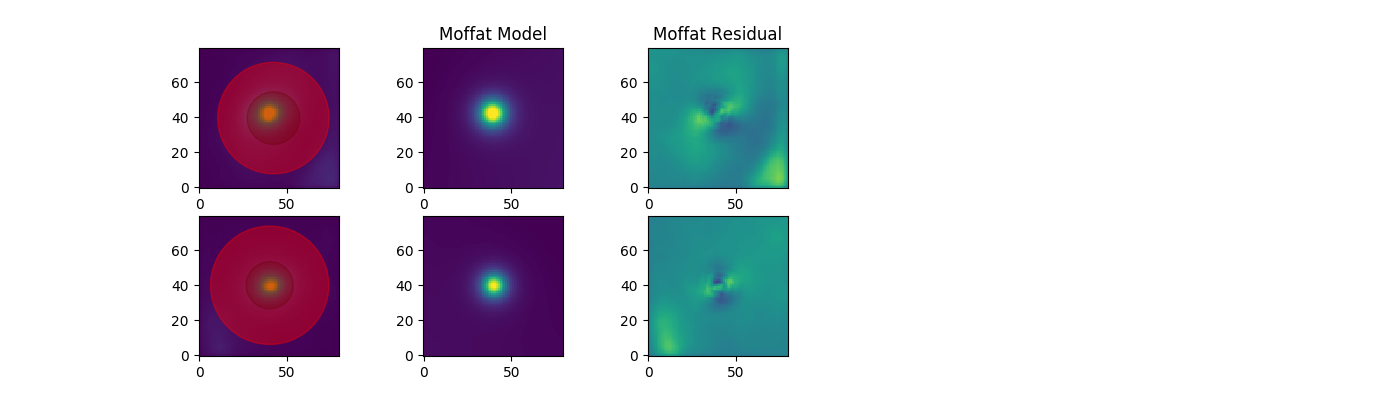

In [41]:
# Cluster member positions
y_cm1,x_cm1 = (233,90)
y_cm2,x_cm2 = (538,160) 
d = 40

# Models 1: Moffat plus a background
bg = models.Polynomial2D(1)
cm1_moffat = models.Moffat2D(amplitude=1.,x_0=d,y_0=d,alpha=1,gamma=1) +  bg
cm2_moffat = models.Moffat2D(amplitude=1.,x_0=d,y_0=d,alpha=1,gamma=1) + bg

# convolve hst data
cm1_data = hst_im[y_cm1-d:y_cm1+d,x_cm1-d:x_cm1+d]
# Gamma in Sinfoni : 2.45 pixel --> Gamma in HST = 2.45 / 3.4677218823453E-5 * 8.3333333333333E-6 = 0.588
cm1_data = convolve(cm1_data,Moffat2DKernel(gamma= 0.588 , alpha = 0.75))
y, x = np.mgrid[:cm1_data.shape[0], : cm1_data.shape[1]]
m_cm1 = fit_cm(cm1_moffat,x,y,cm1_data)

cm2_data = hst_im[y_cm2-d:y_cm2+d,x_cm2-d:x_cm2+d]
cm2_data = convolve(cm2_data,Moffat2DKernel(gamma= 0.588 , alpha = 0.75))
m_cm2 = fit_cm(cm2_moffat,x,y,cm2_data)

print('Moffat')
print('\t\t\tCM1\tCM2')
print('Chi2\t\t\t%0.2f %0.2f'%(np.sum((cm1_data - m_cm1(x, y))**2),np.sum((cm2_data - m_cm2(x, y))**2)))
print('FWHM\t\t\t%0.4f %0.4f'%(fwhm(m_cm1.alpha_0,m_cm1.gamma_0),fwhm(m_cm2.alpha_0,m_cm2.gamma_0)))
print('FWHM(")\t\t\t%0.4f %0.4f'%(fwhm(m_cm1.alpha_0,m_cm1.gamma_0)*0.03,fwhm(m_cm2.alpha_0,m_cm2.gamma_0)*0.03))
for name,p1,p2 in zip(m_cm1.param_names,m_cm1.parameters,m_cm2.parameters):
    print('%15s\t\t%0.2f\t%0.2f'%(name,p1,p2))

    
# Photometry
print('\n\nPhotometry inside the SINFONI apperture')
phot_cm1 = measure_flux_in_apperture(cm1_data,m_cm1.x_0_0,m_cm1.y_0_0,31.84,mean_bg)
print('CM1 pix sum %0.2f and photometry %0.2f mag or %0.4e erg/cm2/s'%(phot_cm1,hst_magnitudes_F125W(phot_cm1).value,phot_cm1*2.2132778E-20))
phot_cm2 = measure_flux_in_apperture(cm2_data,m_cm2.x_0_0,m_cm2.y_0_0,33.81,mean_bg)
print('CM2 pix sum %0.2f and photometry %0.2f mag or %0.4e erg/cm2/s'%(phot_cm2,hst_magnitudes_F125W(phot_cm2).value,phot_cm2*2.2132778E-20))


# Plots
plt.figure(figsize=(14, 4))

ax = plt.subplot(2, 5, 1)
plt.imshow(cm1_data, origin='lower', interpolation='nearest', vmin=0, vmax=1)
ax.add_artist(Circle((m_cm1.y_0_0.value,m_cm1.x_0_0.value), radius=1.27*fwhm(m_cm1.alpha_0,m_cm1.gamma_0), alpha=0.3,color='k'))
ax.add_artist(Circle((m_cm1.y_0_0.value,m_cm1.x_0_0.value), radius=31.84, alpha=0.4,color='r'))
plt.subplot(2, 5, 2)
plt.imshow(m_cm1(x, y), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.title("Moffat Model")
plt.subplot(2, 5, 3)
plt.imshow(cm1_data - m_cm1(x, y), origin='lower', interpolation='nearest', vmin=-0.1,vmax=0.1)
plt.title("Moffat Residual")

ax2 = plt.subplot(2, 5, 6)
plt.imshow(cm2_data, origin='lower', interpolation='nearest', vmin=0, vmax=1)
ax2.add_artist(Circle((m_cm2.x_0_0.value,m_cm2.y_0_0.value), radius=1.27*fwhm(m_cm2.alpha_0,m_cm2.gamma_0), alpha=0.3,color='k'))
ax2.add_artist(Circle((m_cm2.x_0_0.value,m_cm2.y_0_0.value), radius=33.81, alpha=0.4,color='r'))
plt.subplot(2, 5, 7)
plt.imshow(m_cm2(x, y), origin='lower', interpolation='nearest', vmin=0,vmax=1)
plt.subplot(2, 5, 8)
plt.imshow(cm2_data - m_cm2(x, y), origin='lower', interpolation='nearest', vmin=-0.1,vmax=0.1)

## Summary

**Seeing:**

    HST: 0.2331", 0.2791"
    SINFONI: 0.7520", 0.7986"

**Photometry**:


    Using 1.27 FWHM for both
    
| Cluster Member  | HST (mag)  |  SINFONI (mag)  | HST-SINF | HST (erg/cm2/A)  |  SINFONI (erg/cm2/A)  | HST/SINF|
|---|---|---|
|1  | 20.44 |19.70 | 0.74  | 4.6054e-18 | 9.1893e-18 | 0.50 |
|2  | 20.87 |20.04 | 0.83  | 3.0994e-18 | 6.7471e-18 | 0.46 |

    
    Using same aperture as in SINFONI

| Cluster Member  | HST (mag)  |  SINFONI (mag)  | HST-SINF | HST (erg/cm2/A)  |  SINFONI (erg/cm2/A)  | HST/SINF|
|---|---|---|
|1  | 19.92 |19.70 | 0.22 | 7.5483e-18 | 9.1893e-18 | 0.8214 |
|2  | 20.25 |20.04 | 0.21 | 5.5392e-18 | 6.7471e-18 | 0.8209|


    Using same aperture as in SINFONI in the HST convolved data --> same thing as above

The flux calibration does not seem ok. there is  **0.8-0.2 mag difference** between HST and SINFONI. 

## Fix flux

In [24]:
cube = fits.getdata('../Data/Cubes/Cube_SINFONI_MACS1206_sigmaclipped.fits')
cube_scaled = cube*0.8901

# Repeat fit to make sure all is  fine
pseudo_F125W_scaled = make_F125W_pseudo_narrow_band(cube_scaled, wave_trim)
pseudo_F125W_scaled *=1e19 

# New cut outs
y_cm1,x_cm1 = (47,28) 
y_cm2,x_cm2 = (120,45)
d = 20
cm1_data = pseudo_F125W_scaled[y_cm1-d:y_cm1+d,x_cm1-d:x_cm1+d]
cm2_data = pseudo_F125W_scaled[y_cm2-d:y_cm2+d,x_cm2-d:x_cm2+d]

# Photometry: compare with HST
phot_cm1 = measure_flux_in_apperture(cm1_data,p_cm1.x_0_0,p_cm1.y_0_0,1.27*fwhm(p_cm1.alpha_0,p_cm1.gamma_0),mean_bg)*1e-19
cm2_data_fixed = np.zeros_like(cm1_data)
cm2_data_fixed[:cm2_data.shape[0],:cm2_data.shape[1]] = cm2_data[:,:]
phot_cm2 = measure_flux_in_apperture(cm2_data_fixed,p_cm2.x_0_0,p_cm2.y_0_0,1.27*fwhm(p_cm2.alpha_0,p_cm2.gamma_0),mean_bg)*1e-19

print('CM1 photometry %0.2f (19.92) mag or %0.4e (7.5483e-18) erg/cm2/s'%(sinfoni_magnitude(phot_cm1).value,phot_cm1))
print('CM2 photometry %0.2f (20.25) mag or %0.4e (5.5392e-18) erg/cm2/s'%(sinfoni_magnitude(phot_cm2).value,phot_cm2)) 
print('HST/SINF CM1: %0.2e erg/cm2/s'%(phot_cm1/7.5483e-18))
print('HST/SINF CM2: %0.2e erg/cm2/s'%(phot_cm2/5.5392e-18))
print('Mean HST/SINF: %0.4f'%np.mean((phot_cm1/7.5483e-18,phot_cm2/5.5392e-18)))

HST_cm1 = (19.92, 7.5483e-18)
HST_cm2 = (20.25, 5.5392e-18)

CM1 photometry 19.90 (19.92) mag or 7.6766e-18 (7.5483e-18) erg/cm2/s
CM2 photometry 20.27 (20.25) mag or 5.4282e-18 (5.5392e-18) erg/cm2/s
HST/SINF CM1: 1.02e+00 erg/cm2/s
HST/SINF CM2: 9.80e-01 erg/cm2/s
Mean HST/SINF: 0.9985


In [25]:
# Save cube
header_cube = header.copy()
header_cube['NAXIS'] = 3
header_cube['NAXIS3'] = len(wave[250:trim_pix])
header_cube['CRVAL3'] = wave[250]
header_cube['CRPIX3'] = 1
header_cube['CDELT3'] = wave[1]-wave[0]
header_cube['CUNIT3']= 'Angstrom'
header_cube['SIGCLIP']= 7
header_cube['SIGAXIS'] = 3

fits.writeto('../Data/Cubes/Cube_SINFONI_MACS1206_sigmaclipped_flux_corrected.fits',cube_scaled, header,output_verify='fix',clobber=True)

# Check alignement

Regrid HST to the same grid as the SINFONI data and check if all is fine

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


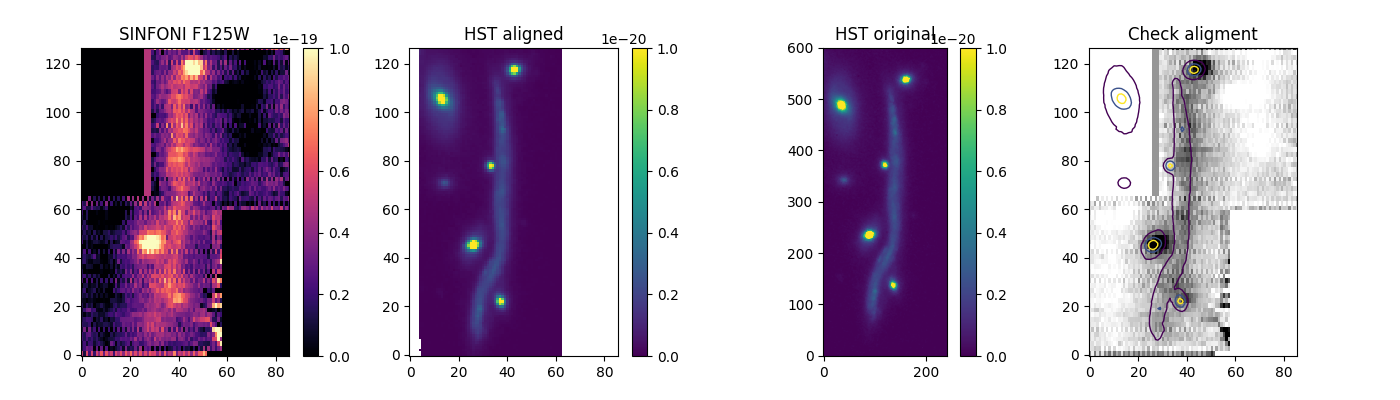

(185.39591608157349, 0.024762376930890007)
(117458, 122.35208333333334)


In [27]:
sinfoni = fits.open('../Data/Images/MACS1206/MACS1206Jwcscorrected.fits')[0]
hst_im = fits.open('../Data/HST/MACS1206_arc_F125w.fits')
hst_aligned , footprint = reproject_exact(hst_im, sinfoni.header,hdu_in=0)
hst_aligned_flux = hst_aligned*2.2132778E-20 # in erg/s/cm2/A
hst_im = hst_im[0].data

fig, ax = plt.subplots(1,4,figsize=(14,4))
fig.subplots_adjust(left=0.05,right=0.95)
cax2 =ax[0].imshow(pseudo_F125W*1e-19, origin='lower', cmap=plt.cm.magma,vmin=0, vmax=1e-19)
cax3 =ax[1].imshow(hst_aligned_flux, origin='lower', cmap=plt.cm.viridis,vmin=0, vmax=1e-20)
cax4 =ax[2].imshow(hst_im*2.2132778E-20,origin='lower', cmap=plt.cm.viridis,vmin=0, vmax=1e-20)
plt.colorbar(cax2,ax=ax[0])
plt.colorbar(cax3,ax=ax[1])
plt.colorbar(cax4,ax=ax[2])
ax[3].imshow(pseudo_F125W*1e-19, origin='lower', cmap=plt.cm.Greys,vmin=0, vmax=1e-19)
ax[3].contour(hst_aligned_flux,cmap=plt.cm.viridis,linewidths=1.,levels=[0.1e-20,0.3e-20,0.9e-20])

ax[0].set_title('SINFONI F125W')
ax[1].set_title('HST aligned')
ax[2].set_title('HST original')
ax[3].set_title('Check aligment')

# Check if fluxes are still the same
print(np.nansum(hst_aligned),np.nanmean(hst_aligned))
print(np.nansum(hst_im[0].data),np.nanmean(hst_im[0].data))

### Data doesn't seem perfectly aligned. 

We could calculate the average difference of the central position of CM1 and CM2 in HST and SINFONI and try to correct for it.
But here I'm being lazy and just correct it manually

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


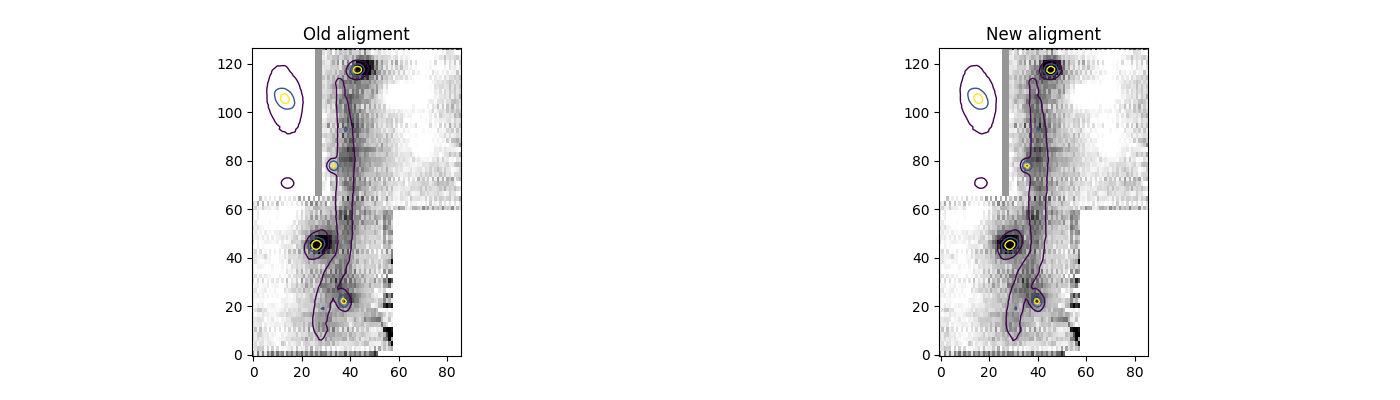

Text(0.5,1,u'New aligment')

In [28]:
hst_im = fits.open('../Data/HST/MACS1206_arc_F125w.fits')
sinfoni_fixed = sinfoni.copy()
sinfoni_fixed.header['CRPIX1'] += 2.5

hst_aligned_v2 , footprint = reproject_exact(hst_im, sinfoni_fixed.header,hdu_in=0)
hst_aligned_flux_v2 = hst_aligned_v2*2.2132778E-20 # in erg/s/cm2/A
hst_im = hst_im[0].data

fig, ax = plt.subplots(1,2,figsize=(14,4))
fig.subplots_adjust(left=0.05,right=0.95)
ax[0].imshow(pseudo_F125W*1e-19, origin='lower', cmap=plt.cm.Greys,vmin=0, vmax=1e-19)
ax[0].contour(hst_aligned_flux,cmap=plt.cm.viridis,linewidths=1.,levels=[0.1e-20,0.3e-20,0.9e-20])
ax[1].imshow(pseudo_F125W*1e-19, origin='lower', cmap=plt.cm.Greys,vmin=0, vmax=1e-19)
ax[1].contour(hst_aligned_flux_v2,cmap=plt.cm.viridis,linewidths=1.,levels=[0.1e-20,0.3e-20,0.9e-20])
ax[0].set_title('Old aligment')
ax[1].set_title('New aligment')

In [29]:
## Save corrected header
sinfoni_fixed.writeto('../Data/Images/MACS1206/MACS1206_aligned_wcs.fits',overwrite=True)

## Make PSF file

<IPython.core.display.Javascript object>


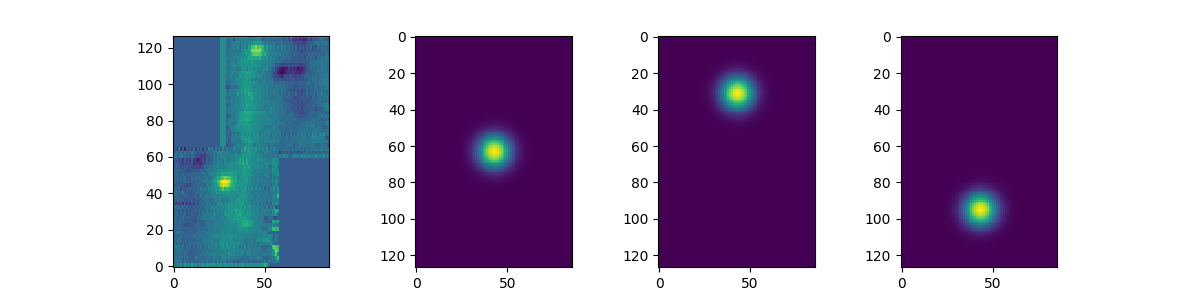

In [17]:
from astropy.modeling.functional_models import Gaussian2D

pseudo_nb = fits.getdata('../Data/Images/MACS1206/MACS1206_SINFONI_pseudoF125W.fits')
y, x = np.mgrid[:pseudo_nb.shape[0], :pseudo_nb.shape[1]]
sigma_pix = np.mean((6.0162,6.3890))

gauss = Gaussian2D(amplitude=1, x_mean=pseudo_nb.shape[1]/2 , y_mean=pseudo_nb.shape[0]/2, x_stddev = sigma_pix, y_stddev=sigma_pix)
gauss2 = Gaussian2D(amplitude=1, x_mean=pseudo_nb.shape[1]/2 , y_mean=pseudo_nb.shape[0]/4, x_stddev = sigma_pix, y_stddev=sigma_pix)
gauss3 = Gaussian2D(amplitude=1, x_mean=pseudo_nb.shape[1]/2 , y_mean=pseudo_nb.shape[0]*3/4, x_stddev = sigma_pix, y_stddev=sigma_pix)

fig, ax = plt.subplots(1,4,figsize=(12,3))
ax[0].imshow(pseudo_nb,origin='lower')
ax[1].imshow(gauss(x,y))
ax[2].imshow(gauss2(x,y))
ax[3].imshow(gauss3(x,y))

fits.writeto('../Data/Images/MACS1206/PSF_centre.fits',data=gauss(x,y),header=fits.getheader('../Data/Images/MACS1206/MACS1206_SINFONI_pseudoF125W.fits'),overwrite=True)
fits.writeto('../Data/Images/MACS1206/PSF_1.fits',data=gauss2(x,y),header=fits.getheader('../Data/Images/MACS1206/MACS1206_SINFONI_pseudoF125W.fits'),overwrite=True)
fits.writeto('../Data/Images/MACS1206/PSF_2.fits',data=gauss3(x,y),header=fits.getheader('../Data/Images/MACS1206/MACS1206_SINFONI_pseudoF125W.fits'),overwrite=True)